In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import json
from matplotlib import pyplot as plt
import torch 
from torch import nn
from torchinfo import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import trange, tqdm
import seaborn as sns 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Update this path if needed
file_path = '/home/lipplopp/Documents/research/notebook/notebook_1/dataset/radioml2018/versions/2/GOLD_XYZ_OSC.0001_1024.hdf5'

In [5]:
n_channels=2
batch_size=32
# Number of frames per snr/modulation combination for train,valid and test data
nf_train = 1024
nf_valid = 512
nf_test = 256

In [6]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.7,
                  valid_proportion=0.2,
                  test_proportion=0.1,
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [7]:
class RadioML18Dataset(Dataset):
    def __init__(self, mode: str,seed=48,):
        super(RadioML18Dataset, self).__init__()
        
        # load data
        hdf5_file = h5py.File("/home/lipplopp/Documents/research/notebook/notebook_1/dataset/radioml2018/versions/2/GOLD_XYZ_OSC.0001_1024.hdf5",  'r')
        self.modulation_classes = json.load(open("/home/lipplopp/Documents/research/notebook/notebook_1/dataset/radioml2018/versions/2/classes-fixed.json", 'r'))
        self.X = hdf5_file['X']
        self.Y = np.argmax(hdf5_file['Y'], axis=1)
        self.Z = hdf5_file['Z'][:, 0]
        
        train_proportion=(24*26*nf_train)/self.X.shape[0]
        valid_proportion=(24*26*nf_valid)/self.X.shape[0]
        test_proportion=(24*26*nf_test)/self.X.shape[0]
        
        """target_modulations =['OOK', '4ASK', 'BPSK', 'QPSK', '8PSK',
        '16QAM', 'AM-SSB-SC', 'AM-DSB-SC', 'FM', 'GMSK','OQPSK']target 
        modulation class and snr"""   

        # in this line i could change it the target modulation 
        self.target_modulations =['OOK', '4ASK', 'BPSK', 'QPSK', '8PSK',
        '16QAM', 'AM-SSB-SC', 'AM-DSB-SC', 'FM', 'GMSK','OQPSK']

        self.target_snrs = np.unique(self.Z)
        
        self.X_data, self.Y_data, self.Z_data = dataset_split(
                                                                  data = self.X,
                                                                  modulations_classes = self.modulation_classes,
                                                                  modulations = self.Y,
                                                                  snrs = self.Z,
                                                                  mode = mode,
                                                                  train_proportion = train_proportion,
                                                                  valid_proportion = valid_proportion,
                                                                  test_proportion = test_proportion,
                                                                  target_modulations = self.target_modulations,
                                                                  target_snrs  = self.target_snrs,
                                                                  seed=48
                                                                 )   

        # store statistic of whole dataset
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, idx):
        x,y,z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        x,y,z = torch.Tensor(x).transpose(0, 1) , y , z
        return x,y,z

In [ ]:
ds = RadioML18Dataset(mode='test')
data_len = ds.num_data
n_labels=ds.num_lbl
n_snrs = ds.num_snr
frame_size=ds.X.shape[1]

del ds

In [ ]:
dataset = RadioML18Dataset(mode='train')

# Print all modulation classes
print("All Modulation Classes:", dataset.modulation_classes)

In [15]:
import time
st = time.time()
train_dl = DataLoader(dataset=RadioML18Dataset(mode='train'),batch_size=64, shuffle=True, drop_last=True)
valid_dl = DataLoader(dataset=RadioML18Dataset(mode='train'),batch_size=128, shuffle=False, drop_last=False)
test_dl = DataLoader(dataset=RadioML18Dataset(mode='test'),batch_size=128, shuffle=False, drop_last=False)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 69.7834415435791 seconds


In [9]:
class CNN_Block(nn.Module):
    def __init__(self,input_shape,output_shape):
        super().__init__()
        self.net=nn.Sequential(
        nn.Conv1d(input_shape, output_shape, kernel_size=3, padding=1),
        nn.BatchNorm1d(output_shape),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size= 2, stride= 2),
        nn.Dropout(0.25),
        )
        
    def forward(self,x):
        return self.net(x)
    
class CNN_NET(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone=nn.Sequential(
        CNN_Block(2,24),
        CNN_Block(24,24),
        CNN_Block(24,48),
        CNN_Block(48,48), 
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072,128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,n_labels)
        )
        
    def forward(self,x):
        return self.classifier(self.backbone(x))
    


In [2]:
summary(CNN_NET().to('cuda'), (batch_size,n_channels, frame_size))

NameError: name 'summary' is not defined

In [11]:
def train_model(model,verbose=True,device='cuda',num_epoch=30):
    
    model.to(device)
    
    train_loss = torch.zeros(num_epoch)
    train_acc = torch.zeros(num_epoch)
    val_loss = torch.zeros(num_epoch)
    val_acc = torch.zeros(num_epoch)
    
    lr = 1e-3
    optimizer = optim.Adam(list(model.parameters()), lr=lr,weight_decay=1e-5)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.9 )
    criterion = nn.CrossEntropyLoss()
    
    
    for epoch in trange(num_epoch, unit='epochs'):    
        #Trainning phase
        model.train()
        for x,y,z in train_dl:
            # TODO
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss[epoch] += loss.detach().cpu()
            train_acc[epoch] += torch.mean((torch.argmax(logits.to('cpu'), dim=-1) == y.to('cpu')).float())
        #Evaluation phase
        model.eval()
        with torch.no_grad():
            for x,y,z in valid_dl:
                x = x.to(device)
                y = y.to(device)
                logits = model(x)
                loss = criterion(logits,y)
                val_loss[epoch] += loss.detach().cpu()
                val_acc[epoch] += torch.mean((torch.argmax(logits.to('cpu'), dim=-1) == y.to('cpu')).float())
        lr_scheduler.step()
        train_loss[epoch] /= (len(train_dl.dataset) // train_dl.batch_size)
        train_acc[epoch] /= (len(train_dl.dataset) // train_dl.batch_size)
        val_loss[epoch] /= (len(valid_dl.dataset)//valid_dl.batch_size)
        val_acc[epoch] /= (len(valid_dl.dataset)//valid_dl.batch_size)
        if verbose:
            tqdm.write('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch], train_acc[epoch]))
            tqdm.write('Epoch {} (valid) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, val_loss[epoch], val_acc[epoch]))
    return model,[train_loss,train_acc,val_loss,val_acc]

In [ ]:
# def test_model(model, device='cuda'):
def test_model_with_improved_plots(model, device='cuda'):
    model.eval()
    Y_pred_ = []  # Predictions
    Y_true_ = []  # Ground truth
    Z_snr_ = []   # SNR values
    
    target_classes = test_dl.dataset.target_modulations
    target_snrs = test_dl.dataset.target_snrs
    modulation_classes = test_dl.dataset.modulation_classes
    target_modulations_indices = [modulation_classes.index(mod) for mod in target_classes]

    #add debug 
    print(f"target modulation:{target_classes}") 
    print(f"target SNR: {target_snrs}") 
    
    # Initialize accuracy stats DataFrame
    accuracy_stats = pd.DataFrame(
        0.0,
        index=target_classes,
        columns=target_snrs.astype('str'))
    
    # Get predictions
    with torch.no_grad():
        for x, y, z in test_dl:
            # Move tensors to specified device
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)
            
            # Get model predictions on device
            logits = model(x)
            y_pred = torch.argmax(logits, dim=-1)
            
            # Store results
            Y_pred_.append(y_pred.cpu())  # Move back to CPU for storage
            Y_true_.append(y.cpu())
            Z_snr_.append(z.cpu())
    
    # Convert to numpy for easier processing
    Y_pred = torch.cat(Y_pred_).numpy()
    Y_true = torch.cat(Y_true_).numpy()
    Z_snr = torch.cat(Z_snr_).numpy()
    
    # Calculate overall accuracy
    correct_preds = (Y_pred == Y_true).sum()
    total_samples = len(Y_true)
    total_accuracy = round(correct_preds * 100 / total_samples, 2)
    print(f'Accuracy on test dataset: {total_accuracy}%')

    #Count sampels for each modulation type 
    mode_counts = {} 
    for mod_idx,mod_name in enumerate(target_classes): 
        count = np.sum(Y_true == mod_idx) 
        mod_counts[mod_name] = count
        print(f"Modulation {mod_name}: {count} test samples")
        
    # Calculate accuracy per modulation and SNR
    for mod_idx, mod_name in enumerate(target_classes): 
        for snr_idx, snr in enumerate(targer_snrs):
            snr_str = str(snr)

            mask = (Y_true == mod_idx) & (Z_snr == snr)
            total_samples = mask.sum() 
        if total_samples > 0: 
            correct_samples = ((Y_pred == Y_true) & mask).sum()

            accuracy = (correct_sampels * 100 / total_samples) 
            accuracy_stats.loc[mod_name,snr_str] = round(accuracy,2) 
        else: 
            accuracy_stats.loc[mod_name,snr_str] = np.nan 
            pritn(f"warning: no sampel for {mod_name} at SNR = {snr}") 

    return accuracy_stats 
    
    # # Map indices back to original modulation classes if needed
    # for index, value in enumerate(target_modulations_indices):
    #     Y_pred[Y_pred == index] = value
    #     Y_true[Y_true == index] = value
    
    # # Calculate accuracy per modulation and SNR
    # for modu in target_modulations_indices:
    #     mod_class = modulation_classes[modu]
    #     for snr in target_snrs:
    #         snr_str = str(snr)
            
    #         # Find samples for this modulation and SNR
    #         mask = (Y_true == modu) & (Z_snr == snr)
    #         total_samples = mask.sum()
            
    #         if total_samples > 0:
    #             # Count correct predictions
    #             correct_samples = ((Y_pred == Y_true) & mask).sum()
                
    #             # Calculate and store accuracy percentage
    #             accuracy = (correct_samples * 100 / total_samples)
    #             accuracy_stats.loc[mod_class, snr_str] = round(accuracy, 2)
    
    # return accuracy_stats

def plot_improved_test_accuracy(model, device = 'cuda'): 
    """
    Improved plotting function that shows all modulations properly 
    """
    accuracy_df = test_model_with_improved_plots(model,device) 

    plt.figure(figsize = (14,8)) 

    accuracy_long = accuracy_df.reset_index().mel(
        id_vars = ['index'],
        var_name = 'SNR',
        value_name = 'Accuracy'
    )
    accuracy_long.columns = ['Modulation','SNR','Accuracy']

    sns.lineplot(
        data = accuracy_long,
        x = 'SNR',
        y = 'Accuracy',
        hue = 'Modulation', 
        marker = 'o',
        markersize = 8, 
        linewidth = 2
    )

    #Specifically highlights PSK modulations 
    psk_mods = [mod for mod in accuracy_df.index if 'PSK' in mod]
    if psk_mods:
        print(f"Highlighting PSK modulation : {psk_mods}") 
        psk_df = accuracy_long[accuracy_long['Modulation'].isin(psk_mods)]

        for mod in psk_mods: 
            mod_data = psk_df[psk_df['Modulation'] == mod] 
            plt.plot(mod_data['SNR'],mod_data['Accuracy'], 
                     linewidth=3.5,
                     linestyle='--',
                     marker='*',
                     markersize=12)
            
    plt.title('Classification Accuracy vs SNR for Different Modulation Types', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('all_modulations_accuracy.png', dpi=300)
    plt.show()  

    n_rows = (len(accuracy_df.index) + 2) // 3 

    fig,axes = plt.subplots(n_rows,3,figsize = (18,n_rows*4), sharey = True) 
    axes = axes.flatten() 

    for i in range(len(accuracy_df.index), len(axes)): 
        axes[i].set_visible(False) 

    for i, mod in enumerate(accuracy_df.index): 
        ax = axes[i] 

        mod_data = accuracy_df.loc[mod].astype[float]

        ax.bar(mod_data.index,mode_data.values, color ='skyblue' if 'PSK' not in mod else 'red')

        ax.plot(mod_data.index,mod_data.values, 'k--', linewidth=2) 

        ax.set_title(f'{mod}', fontsize=14)
        ax.set_xlabel('SNR (dB)' if i >= len(accuracy_df.index) - 3 else '')
        ax.set_ylabel('Accuracy (%)' if i % 3 == 0 else '')
        ax.set_ylim(0, 105)  # Set y-axis from 0 to 100% with a bit of margin
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    plt.suptitle('Classification Accuracy by Modulation Type', fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for suptitle
    plt.savefig('modulation_accuracy_subplots.png', dpi=300)
    plt.show()
    
    # 3. Also create a heatmap visualization
    plt.figure(figsize=(14, 8))
    sns.heatmap(accuracy_df.astype(float), annot=True, cmap='viridis', fmt='.1f', 
                cbar_kws={'label': 'Accuracy (%)'})
    plt.title('Classification Accuracy Heatmap by Modulation and SNR', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Modulation Type', fontsize=14)
    plt.tight_layout()
    plt.savefig('modulation_accuracy_heatmap.png', dpi=300)
    plt.show()
    
    return accuracy_df
    
def plot_training_history(model_name:str, history:list):
    plt.figure(figsize=(10, 6))
    plt.title(f'Training of {model_name} model on radioml2018')
    plt.xlabel('Epochs')   
    plt.plot(history[0], label='train_loss')
    plt.plot(history[1], label='train_accuracy')
    plt.plot(history[2], label='valid_loss')
    plt.plot(history[3], label='valid_accuracy')
    plt.legend(loc="upper left")
    plt.show()
    
# def plot_test_accuracy(model, device='cuda'):
#     accuracy_df = test_model(model, device)
    
#     fig, axes = plt.subplots(len(test_dl.dataset.target_modulations), 1, figsize=(12, 8), sharex=True, sharey=True)
#     fig.subplots_adjust(hspace=0.4)
#     fig.supylabel('Accuracy (%)')
#     fig.supxlabel('Signal to noise ratios (dB)')
    
#     # Handle the case where there's only one modulation
#     if len(test_dl.dataset.target_modulations) == 1:
#         axes = [axes]
    
#     for index, ax in enumerate(axes):
#         ax.set_title(accuracy_df.index[index])
#         ax.bar(accuracy_df.iloc[index].index, accuracy_df.iloc[index].values)
#         ax.set_ylim(0, 100)  # Set y-axis from 0 to 100%
        
#     plt.tight_layout()
#     plt.show()
    
#     return accuracy_df  # Return the DataFrame for potential further analysis
def check_dataset_distribution(test_dl):
    """
    Analyze the distribution of modulations in the dataset
    """
    # Get dataset
    dataset = test_dl.dataset
    
    # Analyze distribution
    mod_counts = {}
    snr_mod_counts = {}
    
    # Initialize counts for all modulations
    for mod in dataset.target_modulations:
        mod_counts[mod] = 0
    
    # Count occurrences of each modulation
    for i in range(len(dataset)):
        _, mod_idx, snr = dataset[i]
        mod = dataset.target_modulations[mod_idx]
        
        # Count by modulation
        mod_counts[mod] += 1
        
        # Count by modulation and SNR
        if snr not in snr_mod_counts:
            snr_mod_counts[snr] = {}
        if mod not in snr_mod_counts[snr]:
            snr_mod_counts[snr][mod] = 0
        snr_mod_counts[snr][mod] += 1
    
    print("Modulation distribution in dataset:")
    for mod, count in mod_counts.items():
        print(f"  {mod}: {count} samples")
    
    # Special check for PSK modulations
    psk_mods = [mod for mod in dataset.target_modulations if 'PSK' in mod]
    print("\nPSK modulation distribution:")
    for mod in psk_mods:
        print(f"\n{mod} distribution across SNRs:")
        for snr in sorted(snr_mod_counts.keys()):
            count = snr_mod_counts[snr].get(mod, 0)
            print(f"  SNR {snr}dB: {count} samples")
    
    return mod_counts, snr_mod_counts
    
# def train_test_plots(model, model_name, verbose=False, device='cuda', num_epoch=30):
#     model, train_history = train_model(model, verbose=verbose, device=device, num_epoch=num_epoch)
#     torch.save(model, f'{model_name}.pth')
#     plot_training_history(model_name, train_history)
#     accuracy_results = plot_test_accuracy(model, device)
#     del model
#     return train_history, accuracy_results

def improved_train_test_plots(model, model_name, verbose=False, device='cuda', num_epoch=30):
    # First check the dataset distribution
    print("Analyzing test dataset distribution...")
    mod_counts, snr_mod_counts = check_dataset_distribution(test_dl)
    
    # Train the model
    print(f"\nTraining {model_name}...")
    model, train_history = train_model(model, verbose=verbose, device=device, num_epoch=num_epoch)
    torch.save(model, f'{model_name}.pth')
    
    # Plot training history
    plot_training_history(model, train_history) 
    
    # Plot test accuracy with improved visualization
    print("\nEvaluating and plotting test accuracy...")
    accuracy_results = plot_improved_test_accuracy(model, device)
    
    return model, train_history, accuracy_results

In [12]:
# def train_test_plots(model,model_name,verbose=False,device='cuda',num_epoch=30):
#     model, train_history = train_model(model,verbose=verbose,device=device,num_epoch=num_epoch)
#     torch.save(model,f'{model_name}.pth')
#     plot_training_history(model_name,train_history)
#     plot_test_accuracy(model)
#     del model

In [13]:
def test_model_with_improved_plots(model, device='cuda'):
    model.eval()
    Y_pred_ = []  # Predictions
    Y_true_ = []  # Ground truth
    Z_snr_ = []   # SNR values
    
    target_classes = test_dl.dataset.target_modulations
    target_snrs = test_dl.dataset.target_snrs
    modulation_classes = test_dl.dataset.modulation_classes
    target_modulations_indices = [modulation_classes.index(mod) for mod in target_classes]

    # Add debug 
    print(f"target modulation:{target_classes}") 
    print(f"target SNR: {target_snrs}") 
    
    # Initialize accuracy stats DataFrame
    accuracy_stats = pd.DataFrame(
        0.0,
        index=target_classes,
        columns=target_snrs.astype('str'))
    
    # Get predictions with tqdm progress bar
    test_loader = tqdm(test_dl, desc="Testing model", leave=True)
    
    with torch.no_grad():
        for x, y, z in test_loader:
            # Move tensors to specified device
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)
            
            # Get model predictions on device
            logits = model(x)
            y_pred = torch.argmax(logits, dim=-1)
            
            # Store results
            Y_pred_.append(y_pred.cpu())  # Move back to CPU for storage
            Y_true_.append(y.cpu())
            Z_snr_.append(z.cpu())
            
            # Free up memory
            del x, y, z, logits, y_pred
            torch.cuda.empty_cache() if device == 'cuda' else None
    
    # Convert to numpy for easier processing
    Y_pred = torch.cat(Y_pred_).numpy()
    Y_true = torch.cat(Y_true_).numpy()
    Z_snr = torch.cat(Z_snr_).numpy()
    
    # Clear lists to free memory
    del Y_pred_, Y_true_, Z_snr_
    
    # Calculate overall accuracy
    correct_preds = (Y_pred == Y_true).sum()
    total_samples = len(Y_true)
    total_accuracy = round(correct_preds * 100 / total_samples, 2)
    print(f'Accuracy on test dataset: {total_accuracy}%')

    # Count samples for each modulation type 
    mod_counts = {}  # Define mod_counts dictionary here
    for mod_idx, mod_name in enumerate(target_classes): 
        count = np.sum(Y_true == mod_idx) 
        mod_counts[mod_name] = count
        print(f"Modulation {mod_name}: {count} test samples")
    
    # Calculate accuracy per modulation and SNR with progress bar
    mod_snr_progress = tqdm(list(enumerate(target_classes)), 
                           desc="Calculating per-modulation accuracies",
                           leave=True)
    
    for mod_idx, mod_name in mod_snr_progress:
        mod_snr_progress.set_postfix({"modulation": mod_name})
        for snr_idx, snr in enumerate(target_snrs):
            snr_str = str(snr)

            mask = (Y_true == mod_idx) & (Z_snr == snr)
            total_samples = mask.sum() 
            if total_samples > 0: 
                correct_samples = ((Y_pred == Y_true) & mask).sum()
                accuracy = (correct_samples * 100 / total_samples)
                accuracy_stats.loc[mod_name, snr_str] = round(accuracy, 2) 
            else: 
                accuracy_stats.loc[mod_name, snr_str] = np.nan 
                print(f"Warning: no samples for {mod_name} at SNR = {snr}")

    return accuracy_stats, mod_counts  # Return mod_counts too

def plot_improved_test_accuracy(model, device='cuda'): 
    """
    Improved plotting function that shows all modulations properly 
    """
    accuracy_df, mod_counts = test_model_with_improved_plots(model, device) 

    plt.figure(figsize=(14, 8)) 

    accuracy_long = accuracy_df.reset_index().melt(  # Fixed typo: mel -> melt
        id_vars=['index'],
        var_name='SNR',
        value_name='Accuracy'
    )
    accuracy_long.columns = ['Modulation', 'SNR', 'Accuracy']

    sns.lineplot(
        data=accuracy_long,
        x='SNR',
        y='Accuracy',
        hue='Modulation', 
        marker='o',
        markersize=8, 
        linewidth=2
    )

    # Specifically highlights PSK modulations 
    psk_mods = [mod for mod in accuracy_df.index if 'PSK' in mod]
    if psk_mods:
        print(f"Highlighting PSK modulation: {psk_mods}") 
        psk_df = accuracy_long[accuracy_long['Modulation'].isin(psk_mods)]

        for mod in psk_mods: 
            mod_data = psk_df[psk_df['Modulation'] == mod] 
            plt.plot(mod_data['SNR'], mod_data['Accuracy'], 
                     linewidth=3.5,
                     linestyle='--',
                     marker='*',
                     markersize=12)
            
    plt.title('Classification Accuracy vs SNR for Different Modulation Types', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('all_modulations_accuracy.png', dpi=300)
    plt.show()  

    n_rows = (len(accuracy_df.index) + 2) // 3 

    fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows*4), sharey=True) 
    axes = axes.flatten() 

    for i in range(len(accuracy_df.index), len(axes)): 
        axes[i].set_visible(False) 

    for i, mod in enumerate(accuracy_df.index): 
        ax = axes[i] 

        mod_data = accuracy_df.loc[mod].astype(float)  # Fixed typo: astype[float] -> astype(float)

        ax.bar(mod_data.index, mod_data.values, color='skyblue' if 'PSK' not in mod else 'red')  # Fixed typo: mode_data -> mod_data

        ax.plot(mod_data.index, mod_data.values, 'k--', linewidth=2) 

        ax.set_title(f'{mod}', fontsize=14)
        ax.set_xlabel('SNR (dB)' if i >= len(accuracy_df.index) - 3 else '')
        ax.set_ylabel('Accuracy (%)' if i % 3 == 0 else '')
        ax.set_ylim(0, 105)  # Set y-axis from 0 to 100% with a bit of margin
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    plt.suptitle('Classification Accuracy by Modulation Type', fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for suptitle
    plt.savefig('modulation_accuracy_subplots.png', dpi=300)
    plt.show()
    
    # 3. Also create a heatmap visualization
    plt.figure(figsize=(14, 8))
    sns.heatmap(accuracy_df.astype(float), annot=True, cmap='viridis', fmt='.1f', 
                cbar_kws={'label': 'Accuracy (%)'})
    plt.title('Classification Accuracy Heatmap by Modulation and SNR', fontsize=16)
    plt.xlabel('Signal-to-Noise Ratio (dB)', fontsize=14)
    plt.ylabel('Modulation Type', fontsize=14)
    plt.tight_layout()
    plt.savefig('modulation_accuracy_heatmap.png', dpi=300)
    plt.show()
    
    return accuracy_df
    
def plot_training_history(model_name, history):  # Changed parameter to model_name
    plt.figure(figsize=(10, 6))
    plt.title(f'Training of {model_name} model on radioml2018')
    plt.xlabel('Epochs')   
    plt.plot(history[0], label='train_loss')
    plt.plot(history[1], label='train_accuracy')
    plt.plot(history[2], label='valid_loss')
    plt.plot(history[3], label='valid_accuracy')
    plt.legend(loc="upper left")
    plt.savefig(f'{model_name}_training_history.png', dpi=300)  # Added saving the plot
    plt.show()

def check_dataset_distribution(test_dl):
    """
    Analyze the distribution of modulations in the dataset
    """
    # Get dataset
    dataset = test_dl.dataset
    
    # Analyze distribution
    mod_counts = {}
    snr_mod_counts = {}
    
    # Initialize counts for all modulations
    for mod in dataset.target_modulations:
        mod_counts[mod] = 0
    
    # Set up progress bar
    progress_bar = tqdm(range(len(dataset)), desc="Analyzing dataset", leave=True)
    
    # Count occurrences of each modulation
    for i in progress_bar:
        _, mod_idx, snr = dataset[i]
        mod = dataset.target_modulations[mod_idx]
        
        # Count by modulation
        mod_counts[mod] += 1
        
        # Count by modulation and SNR
        if snr not in snr_mod_counts:
            snr_mod_counts[snr] = {}
        if mod not in snr_mod_counts[snr]:
            snr_mod_counts[snr][mod] = 0
        snr_mod_counts[snr][mod] += 1
        
        # Update progress bar with current modulation
        if i % 100 == 0:  # Update less frequently to improve performance
            progress_bar.set_postfix({"current_mod": mod, "snr": snr})
    
    print("Modulation distribution in dataset:")
    for mod, count in mod_counts.items():
        print(f"  {mod}: {count} samples")
    
    # Special check for PSK modulations
    psk_mods = [mod for mod in dataset.target_modulations if 'PSK' in mod]
    print("\nPSK modulation distribution:")
    for mod in psk_mods:
        print(f"\n{mod} distribution across SNRs:")
        for snr in sorted(snr_mod_counts.keys()):
            count = snr_mod_counts[snr].get(mod, 0)
            print(f"  SNR {snr}dB: {count} samples")
    
    return mod_counts, snr_mod_counts

def improved_train_test_plots(model, model_name, verbose = True,device='cuda', num_epoch=30):
    # First check the dataset distribution
    print("Analyzing test dataset distribution...")
    mod_counts, snr_mod_counts = check_dataset_distribution(test_dl)
    
    # Train the model with tqdm progress
    print(f"\nTraining {model_name}...")
    model, train_history = train_model(model, verbose=verbose, device=device, num_epoch=num_epoch)
    torch.save(model, f'{model_name}.pth')
    
    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(model_name, train_history)  # Changed to pass model_name instead of model
    
    # Plot test accuracy with improved visualization
    print("\nEvaluating and plotting test accuracy...")
    accuracy_results = plot_improved_test_accuracy(model, device)
    
    return model, train_history, accuracy_results

Analyzing test dataset distribution...


Analyzing dataset: 100%|█| 73216/73216 [00


Modulation distribution in dataset:
  OOK: 6656 samples
  4ASK: 6656 samples
  BPSK: 6656 samples
  QPSK: 6656 samples
  8PSK: 6656 samples
  16QAM: 6656 samples
  AM-SSB-SC: 6656 samples
  AM-DSB-SC: 6656 samples
  FM: 6656 samples
  GMSK: 6656 samples
  OQPSK: 6656 samples

PSK modulation distribution:

BPSK distribution across SNRs:
  SNR -20dB: 256 samples
  SNR -18dB: 256 samples
  SNR -16dB: 256 samples
  SNR -14dB: 256 samples
  SNR -12dB: 256 samples
  SNR -10dB: 256 samples
  SNR -8dB: 256 samples
  SNR -6dB: 256 samples
  SNR -4dB: 256 samples
  SNR -2dB: 256 samples
  SNR 0dB: 256 samples
  SNR 2dB: 256 samples
  SNR 4dB: 256 samples
  SNR 6dB: 256 samples
  SNR 8dB: 256 samples
  SNR 10dB: 256 samples
  SNR 12dB: 256 samples
  SNR 14dB: 256 samples
  SNR 16dB: 256 samples
  SNR 18dB: 256 samples
  SNR 20dB: 256 samples
  SNR 22dB: 256 samples
  SNR 24dB: 256 samples
  SNR 26dB: 256 samples
  SNR 28dB: 256 samples
  SNR 30dB: 256 samples

QPSK distribution across SNRs:
  SNR

  3%|  | 1/30 [00:36<17:29, 36.19s/epochs]

Epoch 0 (train) -- loss: 1.2318 accuracy: 0.5152
Epoch 0 (valid) -- loss: 1.0163 accuracy: 0.6140


  7%|▏ | 2/30 [01:18<18:34, 39.81s/epochs]

Epoch 1 (train) -- loss: 0.9786 accuracy: 0.6266
Epoch 1 (valid) -- loss: 0.9137 accuracy: 0.6632


 10%|▏ | 3/30 [02:03<18:58, 42.18s/epochs]

Epoch 2 (train) -- loss: 0.9216 accuracy: 0.6514
Epoch 2 (valid) -- loss: 0.8657 accuracy: 0.6836


 13%|▎ | 4/30 [02:49<18:55, 43.66s/epochs]

Epoch 3 (train) -- loss: 0.8913 accuracy: 0.6626
Epoch 3 (valid) -- loss: 0.9841 accuracy: 0.6515


 17%|▎ | 5/30 [03:36<18:44, 44.97s/epochs]

Epoch 4 (train) -- loss: 0.8707 accuracy: 0.6704
Epoch 4 (valid) -- loss: 1.1873 accuracy: 0.6371


 20%|▍ | 6/30 [04:28<18:51, 47.13s/epochs]

Epoch 5 (train) -- loss: 0.8530 accuracy: 0.6776
Epoch 5 (valid) -- loss: 0.8138 accuracy: 0.6970


 23%|▍ | 7/30 [05:20<18:45, 48.92s/epochs]

Epoch 6 (train) -- loss: 0.8426 accuracy: 0.6812
Epoch 6 (valid) -- loss: 0.8063 accuracy: 0.6952


 27%|▌ | 8/30 [06:12<18:18, 49.94s/epochs]

Epoch 7 (train) -- loss: 0.8323 accuracy: 0.6858
Epoch 7 (valid) -- loss: 0.8171 accuracy: 0.6967


 30%|▌ | 9/30 [07:01<17:23, 49.67s/epochs]

Epoch 8 (train) -- loss: 0.8245 accuracy: 0.6885
Epoch 8 (valid) -- loss: 0.7831 accuracy: 0.7079


 33%|▎| 10/30 [07:48<16:12, 48.63s/epochs]

Epoch 9 (train) -- loss: 0.8177 accuracy: 0.6906
Epoch 9 (valid) -- loss: 0.7984 accuracy: 0.7035


 37%|▎| 11/30 [08:34<15:07, 47.77s/epochs]

Epoch 10 (train) -- loss: 0.8111 accuracy: 0.6930
Epoch 10 (valid) -- loss: 0.7911 accuracy: 0.7028


 40%|▍| 12/30 [09:20<14:10, 47.27s/epochs]

Epoch 11 (train) -- loss: 0.8069 accuracy: 0.6946
Epoch 11 (valid) -- loss: 0.7859 accuracy: 0.7084


 43%|▍| 13/30 [10:06<13:20, 47.06s/epochs]

Epoch 12 (train) -- loss: 0.8024 accuracy: 0.6969
Epoch 12 (valid) -- loss: 0.7961 accuracy: 0.7014


 47%|▍| 14/30 [10:53<12:31, 46.95s/epochs]

Epoch 13 (train) -- loss: 0.7973 accuracy: 0.6981
Epoch 13 (valid) -- loss: 0.7696 accuracy: 0.7112


 50%|▌| 15/30 [11:40<11:43, 46.87s/epochs]

Epoch 14 (train) -- loss: 0.7953 accuracy: 0.6992
Epoch 14 (valid) -- loss: 0.7775 accuracy: 0.7081


 53%|▌| 16/30 [12:27<10:58, 47.06s/epochs]

Epoch 15 (train) -- loss: 0.7913 accuracy: 0.7004
Epoch 15 (valid) -- loss: 0.7610 accuracy: 0.7138


 57%|▌| 17/30 [13:14<10:11, 47.04s/epochs]

Epoch 16 (train) -- loss: 0.7901 accuracy: 0.7013
Epoch 16 (valid) -- loss: 0.7738 accuracy: 0.7088


 60%|▌| 18/30 [14:01<09:23, 46.94s/epochs]

Epoch 17 (train) -- loss: 0.7867 accuracy: 0.7028
Epoch 17 (valid) -- loss: 0.7767 accuracy: 0.7103


 63%|▋| 19/30 [14:47<08:34, 46.80s/epochs]

Epoch 18 (train) -- loss: 0.7849 accuracy: 0.7035
Epoch 18 (valid) -- loss: 0.7729 accuracy: 0.7124


 67%|▋| 20/30 [15:34<07:48, 46.80s/epochs]

Epoch 19 (train) -- loss: 0.7840 accuracy: 0.7041
Epoch 19 (valid) -- loss: 0.7637 accuracy: 0.7156


 70%|▋| 21/30 [16:21<07:01, 46.84s/epochs]

Epoch 20 (train) -- loss: 0.7821 accuracy: 0.7046
Epoch 20 (valid) -- loss: 0.7869 accuracy: 0.7081


 73%|▋| 22/30 [17:08<06:14, 46.85s/epochs]

Epoch 21 (train) -- loss: 0.7801 accuracy: 0.7054
Epoch 21 (valid) -- loss: 0.7600 accuracy: 0.7165


 77%|▊| 23/30 [17:54<05:26, 46.71s/epochs]

Epoch 22 (train) -- loss: 0.7770 accuracy: 0.7063
Epoch 22 (valid) -- loss: 0.7543 accuracy: 0.7181


 80%|▊| 24/30 [18:41<04:40, 46.71s/epochs]

Epoch 23 (train) -- loss: 0.7765 accuracy: 0.7068
Epoch 23 (valid) -- loss: 0.7647 accuracy: 0.7145


 83%|▊| 25/30 [19:27<03:53, 46.63s/epochs]

Epoch 24 (train) -- loss: 0.7738 accuracy: 0.7074
Epoch 24 (valid) -- loss: 0.7726 accuracy: 0.7112


 87%|▊| 26/30 [20:14<03:06, 46.66s/epochs]

Epoch 25 (train) -- loss: 0.7740 accuracy: 0.7073
Epoch 25 (valid) -- loss: 0.7620 accuracy: 0.7151


 90%|▉| 27/30 [21:03<02:21, 47.21s/epochs]

Epoch 26 (train) -- loss: 0.7723 accuracy: 0.7078
Epoch 26 (valid) -- loss: 0.7585 accuracy: 0.7195


 93%|▉| 28/30 [21:52<01:35, 47.98s/epochs]

Epoch 27 (train) -- loss: 0.7722 accuracy: 0.7079
Epoch 27 (valid) -- loss: 0.7701 accuracy: 0.7119


 97%|▉| 29/30 [22:42<00:48, 48.40s/epochs]

Epoch 28 (train) -- loss: 0.7711 accuracy: 0.7085
Epoch 28 (valid) -- loss: 0.7805 accuracy: 0.7081


100%|█| 30/30 [23:33<00:00, 47.12s/epochs]


Epoch 29 (train) -- loss: 0.7699 accuracy: 0.7089
Epoch 29 (valid) -- loss: 0.7672 accuracy: 0.7157

Plotting training history...


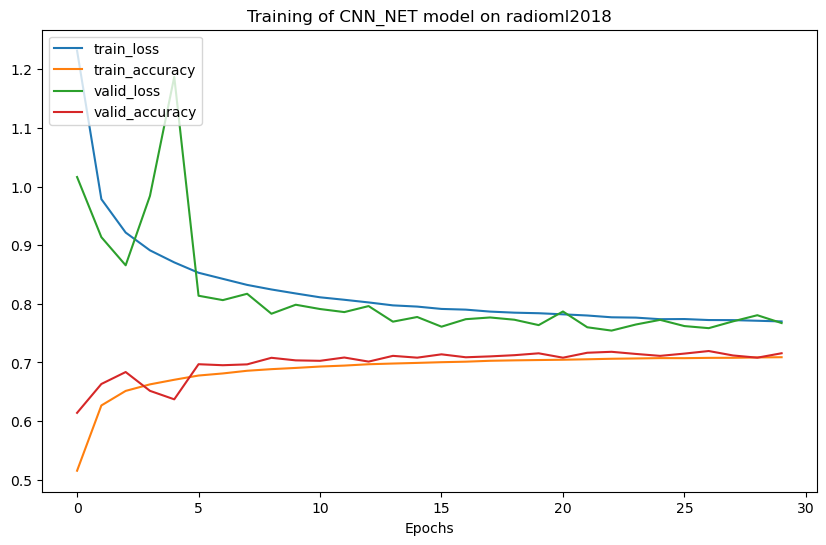


Evaluating and plotting test accuracy...
target modulation:['OOK', '4ASK', 'BPSK', 'QPSK', '8PSK', '16QAM', 'AM-SSB-SC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']
target SNR: [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]


Testing model: 100%|█| 572/572 [00:02<00:0


Accuracy on test dataset: 71.32%
Modulation OOK: 6656 test samples
Modulation 4ASK: 6656 test samples
Modulation BPSK: 6656 test samples
Modulation QPSK: 6656 test samples
Modulation 8PSK: 6656 test samples
Modulation 16QAM: 6656 test samples
Modulation AM-SSB-SC: 6656 test samples
Modulation AM-DSB-SC: 6656 test samples
Modulation FM: 6656 test samples
Modulation GMSK: 6656 test samples
Modulation OQPSK: 6656 test samples


Calculating per-modulation accuracies: 100


Highlighting PSK modulation: ['BPSK', 'QPSK', '8PSK', 'OQPSK']


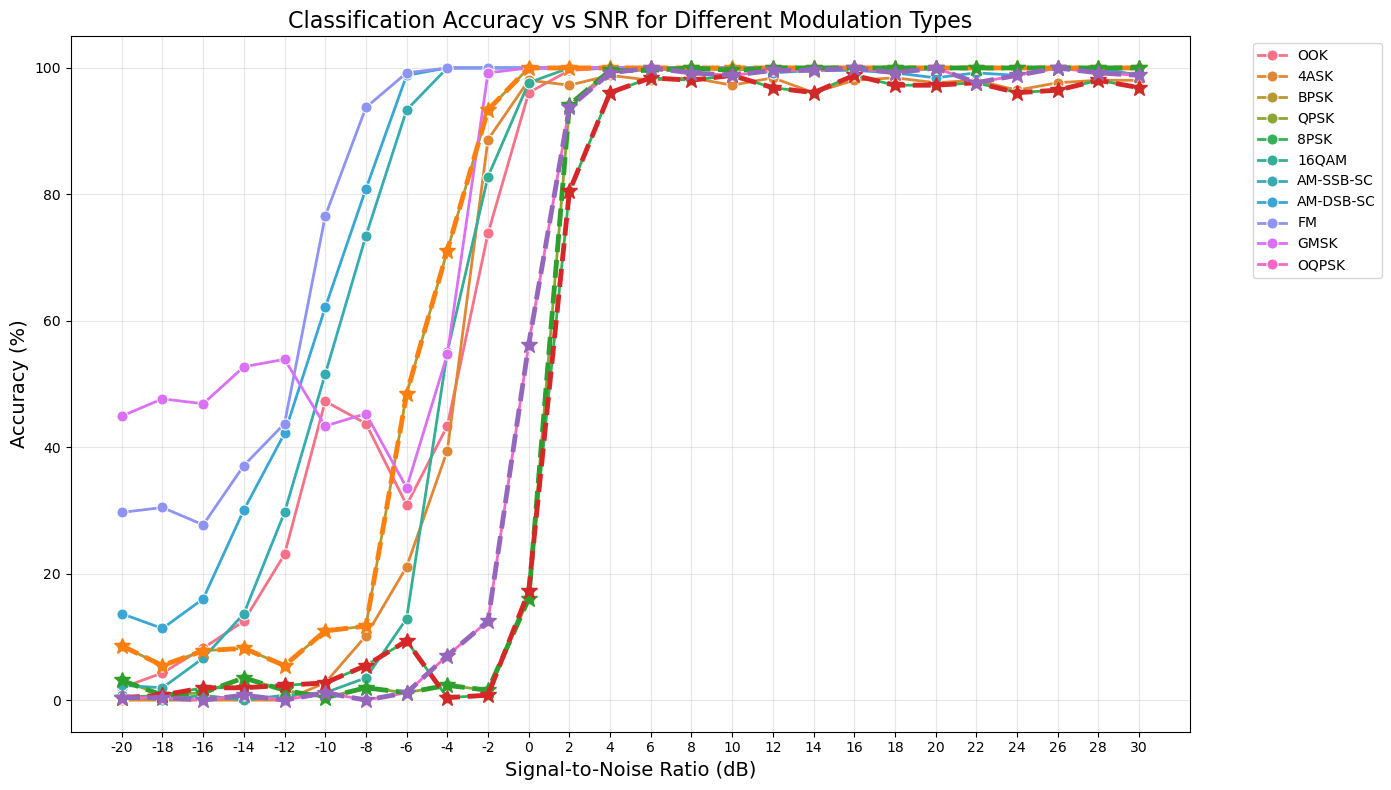

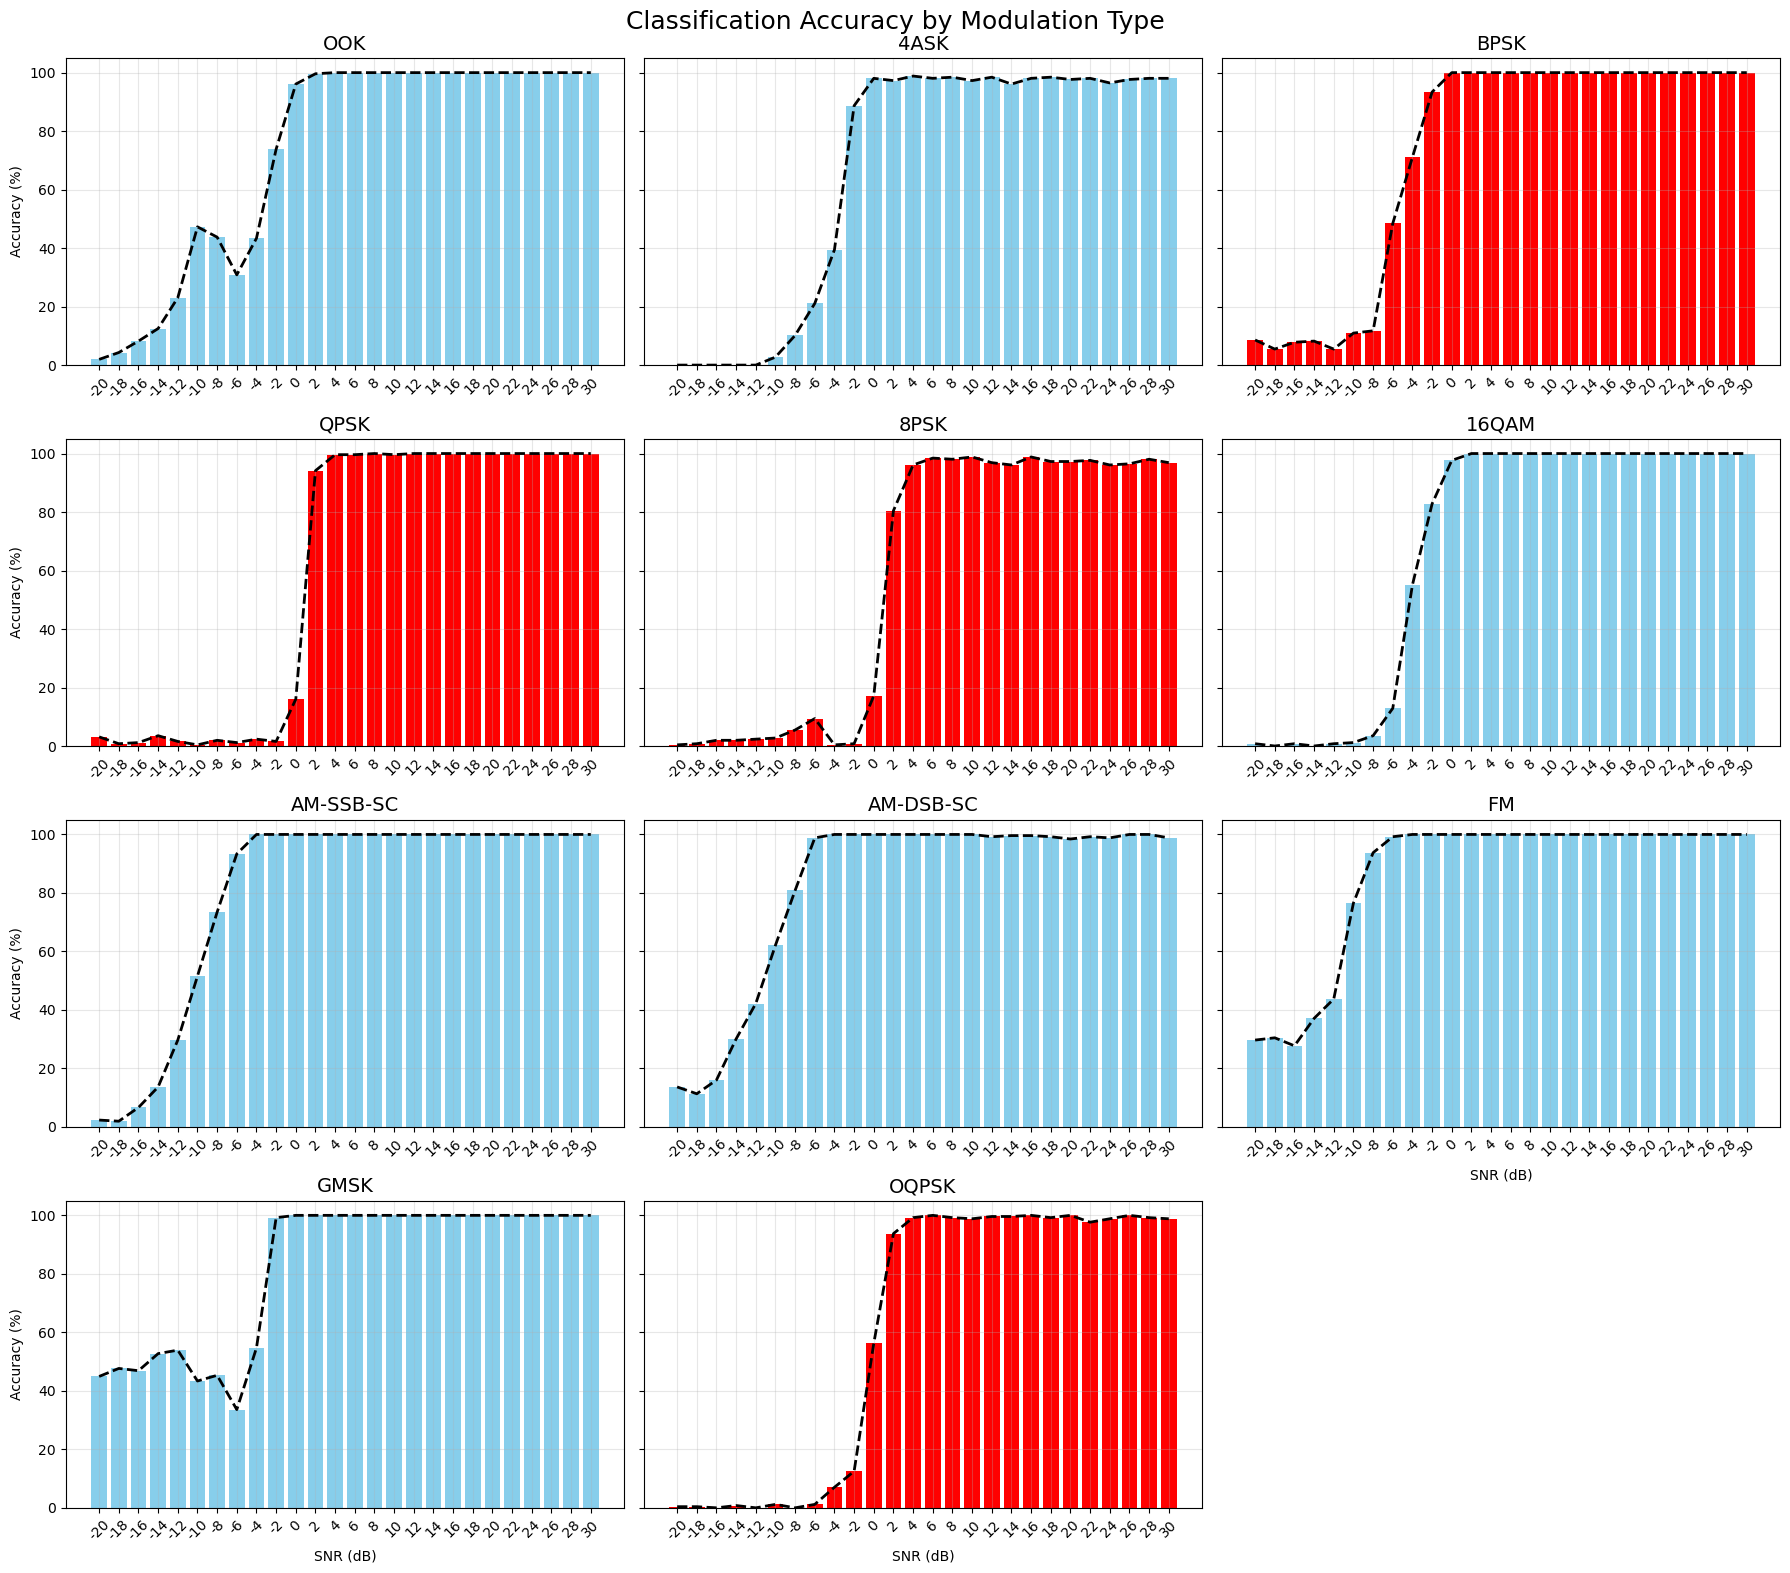

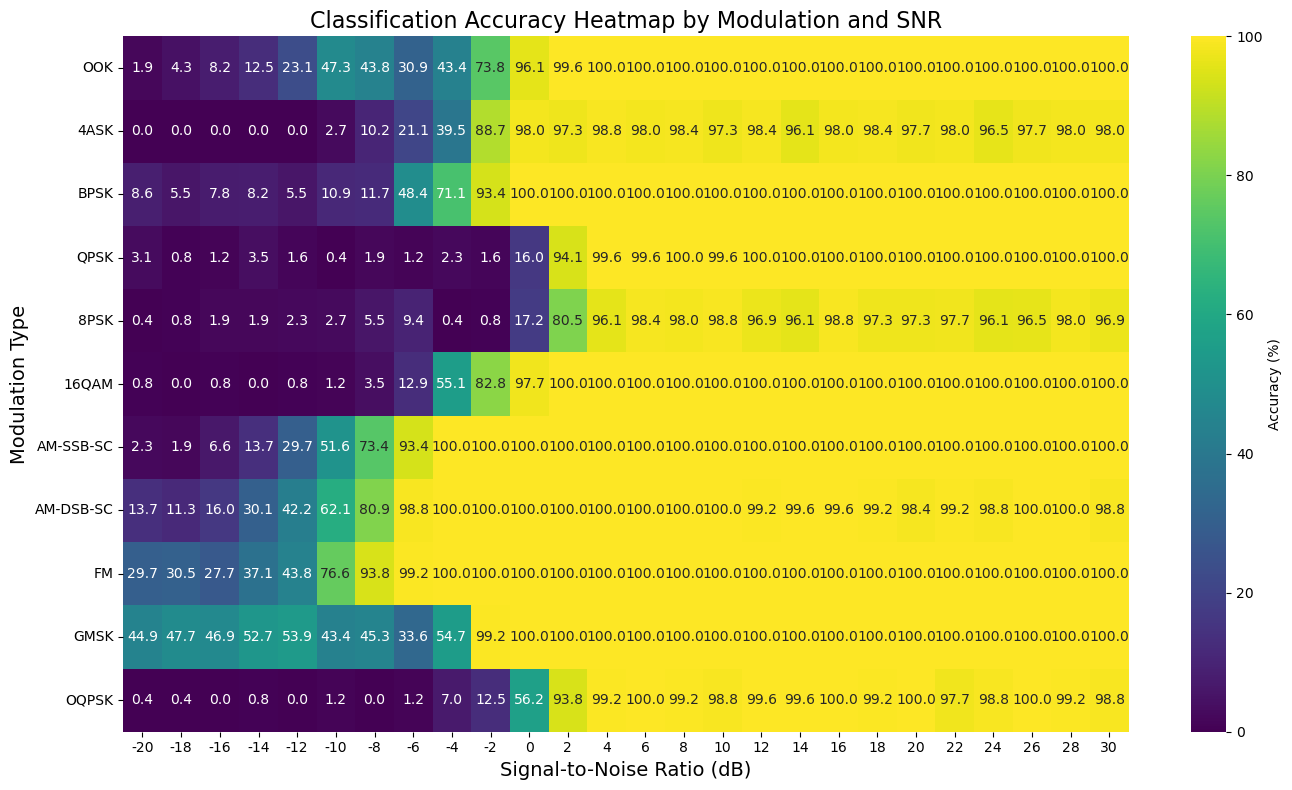

(CNN_NET(
   (backbone): Sequential(
     (0): CNN_Block(
       (net): Sequential(
         (0): Conv1d(2, 24, kernel_size=(3,), stride=(1,), padding=(1,))
         (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU()
         (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (4): Dropout(p=0.25, inplace=False)
       )
     )
     (1): CNN_Block(
       (net): Sequential(
         (0): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
         (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU()
         (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (4): Dropout(p=0.25, inplace=False)
       )
     )
     (2): CNN_Block(
       (net): Sequential(
         (0): Conv1d(24, 48, kernel_size=(3,), stride=(1,), padding=(1,))
         (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, tra

In [18]:
improved_train_test_plots(
    model=CNN_NET(),
    model_name='CNN_NET',  # Name goes here
    device='cuda',
    verbose=True,
    num_epoch=30
)

In [20]:
class DDrCNN(nn.Module):
    """
    Modified DDrCNN with architecture similar to the image model
    - Uses Conv1D blocks with BatchNorm and MaxPool
    - Matches channel progression from the image (24→24→48→48)
    - Maintains dropout rate of 0.25 from the image model
    """
    def __init__(self, input_shape=(2, 1024), num_classes=24):
        super(DDrCNN, self).__init__()
        
        # Convert to 1D architecture like the image model
        self.backbone = nn.Sequential(
            self._make_block(2, 24),
            self._make_block(24, 24),
            self._make_block(24, 48),
            self._make_block(48, 48)
        )
        
        # Calculate flattened dimension
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy = self.backbone(dummy)
            flat_dim = dummy.view(1, -1).size(1)
        
        # Classifier matching the image model
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def _make_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

In [16]:
summary(DDrCNN().to('cuda'), (batch_size,n_channels, frame_size))

Layer (type:depth-idx)                   Output Shape              Param #
DDrCNN                                   [32, 24]                  --
├─Sequential: 1-1                        [32, 48, 64]              --
│    └─Sequential: 2-1                   [32, 24, 512]             --
│    │    └─Conv1d: 3-1                  [32, 24, 1024]            168
│    │    └─BatchNorm1d: 3-2             [32, 24, 1024]            48
│    │    └─ReLU: 3-3                    [32, 24, 1024]            --
│    │    └─MaxPool1d: 3-4               [32, 24, 512]             --
│    │    └─Dropout: 3-5                 [32, 24, 512]             --
│    └─Sequential: 2-2                   [32, 24, 256]             --
│    │    └─Conv1d: 3-6                  [32, 24, 512]             1,752
│    │    └─BatchNorm1d: 3-7             [32, 24, 512]             48
│    │    └─ReLU: 3-8                    [32, 24, 512]             --
│    │    └─MaxPool1d: 3-9               [32, 24, 256]             --
│    │    └

  3%| | 1/30 [00:12<06:13, 12.89s/e

Epoch 0 (train) -- loss: 0.5492 accuracy: 0.7130
Epoch 0 (valid) -- loss: 1.3670 accuracy: 0.6538


  7%| | 2/30 [00:26<06:11, 13.26s/e

Epoch 1 (train) -- loss: 0.4362 accuracy: 0.7620
Epoch 1 (valid) -- loss: 1.5913 accuracy: 0.7354


 10%| | 3/30 [00:39<05:58, 13.29s/e

Epoch 2 (train) -- loss: 0.4113 accuracy: 0.7718
Epoch 2 (valid) -- loss: 1.1690 accuracy: 0.7481


 13%|▏| 4/30 [00:52<05:44, 13.24s/e

Epoch 3 (train) -- loss: 0.3974 accuracy: 0.7782
Epoch 3 (valid) -- loss: 0.5179 accuracy: 0.7625


 17%|▏| 5/30 [01:06<05:32, 13.29s/e

Epoch 4 (train) -- loss: 0.3838 accuracy: 0.7879
Epoch 4 (valid) -- loss: 0.3864 accuracy: 0.7916


 20%|▏| 6/30 [01:19<05:21, 13.38s/e

Epoch 5 (train) -- loss: 0.3726 accuracy: 0.7964
Epoch 5 (valid) -- loss: 0.3521 accuracy: 0.8092


 23%|▏| 7/30 [01:33<05:09, 13.47s/e

Epoch 6 (train) -- loss: 0.3672 accuracy: 0.8020
Epoch 6 (valid) -- loss: 0.3569 accuracy: 0.8111


 27%|▎| 8/30 [01:46<04:55, 13.43s/e

Epoch 7 (train) -- loss: 0.3617 accuracy: 0.8035
Epoch 7 (valid) -- loss: 0.3362 accuracy: 0.8170


 30%|▎| 9/30 [02:00<04:40, 13.36s/e

Epoch 8 (train) -- loss: 0.3575 accuracy: 0.8072
Epoch 8 (valid) -- loss: 0.3313 accuracy: 0.8195


 33%|▎| 10/30 [02:13<04:27, 13.35s/

Epoch 9 (train) -- loss: 0.3538 accuracy: 0.8102
Epoch 9 (valid) -- loss: 0.3345 accuracy: 0.8211


 37%|▎| 11/30 [02:26<04:14, 13.40s/

Epoch 10 (train) -- loss: 0.3502 accuracy: 0.8120
Epoch 10 (valid) -- loss: 0.3285 accuracy: 0.8283


 40%|▍| 12/30 [02:40<04:02, 13.49s/

Epoch 11 (train) -- loss: 0.3461 accuracy: 0.8152
Epoch 11 (valid) -- loss: 0.3412 accuracy: 0.8134


 43%|▍| 13/30 [02:53<03:47, 13.36s/

Epoch 12 (train) -- loss: 0.3407 accuracy: 0.8173
Epoch 12 (valid) -- loss: 0.3267 accuracy: 0.8238


 47%|▍| 14/30 [03:06<03:33, 13.35s/

Epoch 13 (train) -- loss: 0.3384 accuracy: 0.8191
Epoch 13 (valid) -- loss: 0.3264 accuracy: 0.8271


 50%|▌| 15/30 [03:20<03:19, 13.28s/

Epoch 14 (train) -- loss: 0.3379 accuracy: 0.8206
Epoch 14 (valid) -- loss: 0.3194 accuracy: 0.8330


 53%|▌| 16/30 [03:33<03:05, 13.23s/

Epoch 15 (train) -- loss: 0.3353 accuracy: 0.8209
Epoch 15 (valid) -- loss: 0.3215 accuracy: 0.8310


 57%|▌| 17/30 [03:46<02:50, 13.14s/

Epoch 16 (train) -- loss: 0.3328 accuracy: 0.8242
Epoch 16 (valid) -- loss: 0.3180 accuracy: 0.8348


 60%|▌| 18/30 [03:59<02:37, 13.16s/

Epoch 17 (train) -- loss: 0.3309 accuracy: 0.8243
Epoch 17 (valid) -- loss: 0.3238 accuracy: 0.8304


 63%|▋| 19/30 [04:12<02:23, 13.09s/

Epoch 18 (train) -- loss: 0.3294 accuracy: 0.8253
Epoch 18 (valid) -- loss: 0.3228 accuracy: 0.8320


 67%|▋| 20/30 [04:25<02:10, 13.07s/

Epoch 19 (train) -- loss: 0.3287 accuracy: 0.8266
Epoch 19 (valid) -- loss: 0.3199 accuracy: 0.8336


 70%|▋| 21/30 [04:38<01:57, 13.01s/

Epoch 20 (train) -- loss: 0.3277 accuracy: 0.8272
Epoch 20 (valid) -- loss: 0.3206 accuracy: 0.8301


 73%|▋| 22/30 [04:51<01:44, 13.09s/

Epoch 21 (train) -- loss: 0.3274 accuracy: 0.8270
Epoch 21 (valid) -- loss: 0.3216 accuracy: 0.8327


 77%|▊| 23/30 [05:05<01:33, 13.34s/

Epoch 22 (train) -- loss: 0.3261 accuracy: 0.8288
Epoch 22 (valid) -- loss: 0.3238 accuracy: 0.8314


 80%|▊| 24/30 [05:18<01:20, 13.41s/

Epoch 23 (train) -- loss: 0.3262 accuracy: 0.8277
Epoch 23 (valid) -- loss: 0.3208 accuracy: 0.8332


 83%|▊| 25/30 [05:32<01:07, 13.42s/

Epoch 24 (train) -- loss: 0.3240 accuracy: 0.8288
Epoch 24 (valid) -- loss: 0.3207 accuracy: 0.8335


 87%|▊| 26/30 [05:45<00:53, 13.36s/

Epoch 25 (train) -- loss: 0.3259 accuracy: 0.8279
Epoch 25 (valid) -- loss: 0.3168 accuracy: 0.8361


 90%|▉| 27/30 [05:58<00:39, 13.30s/

Epoch 26 (train) -- loss: 0.3233 accuracy: 0.8290
Epoch 26 (valid) -- loss: 0.3284 accuracy: 0.8273


 93%|▉| 28/30 [06:11<00:26, 13.23s/

Epoch 27 (train) -- loss: 0.3238 accuracy: 0.8279
Epoch 27 (valid) -- loss: 0.3205 accuracy: 0.8347


 97%|▉| 29/30 [06:24<00:13, 13.14s/

Epoch 28 (train) -- loss: 0.3235 accuracy: 0.8300
Epoch 28 (valid) -- loss: 0.3182 accuracy: 0.8316


100%|█| 30/30 [06:37<00:00, 13.26s/

Epoch 29 (train) -- loss: 0.3224 accuracy: 0.8297
Epoch 29 (valid) -- loss: 0.3173 accuracy: 0.8341


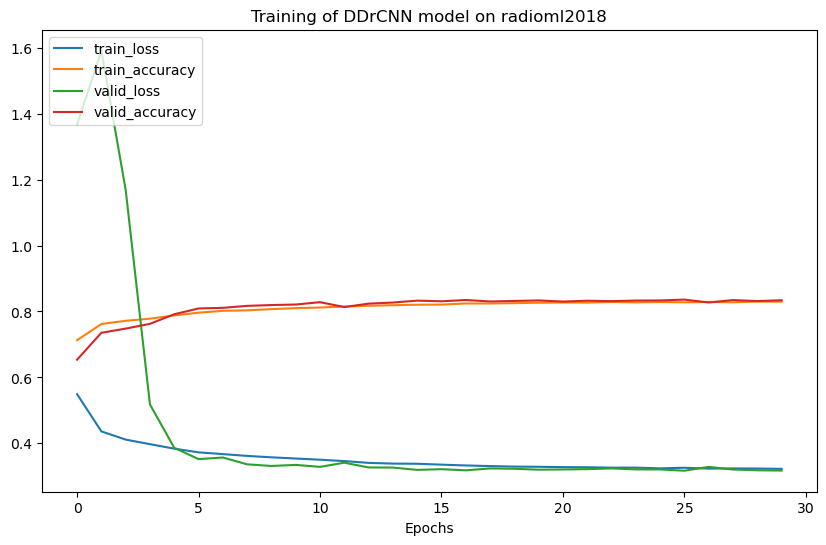

Accuracy on test dataset: 83.4%


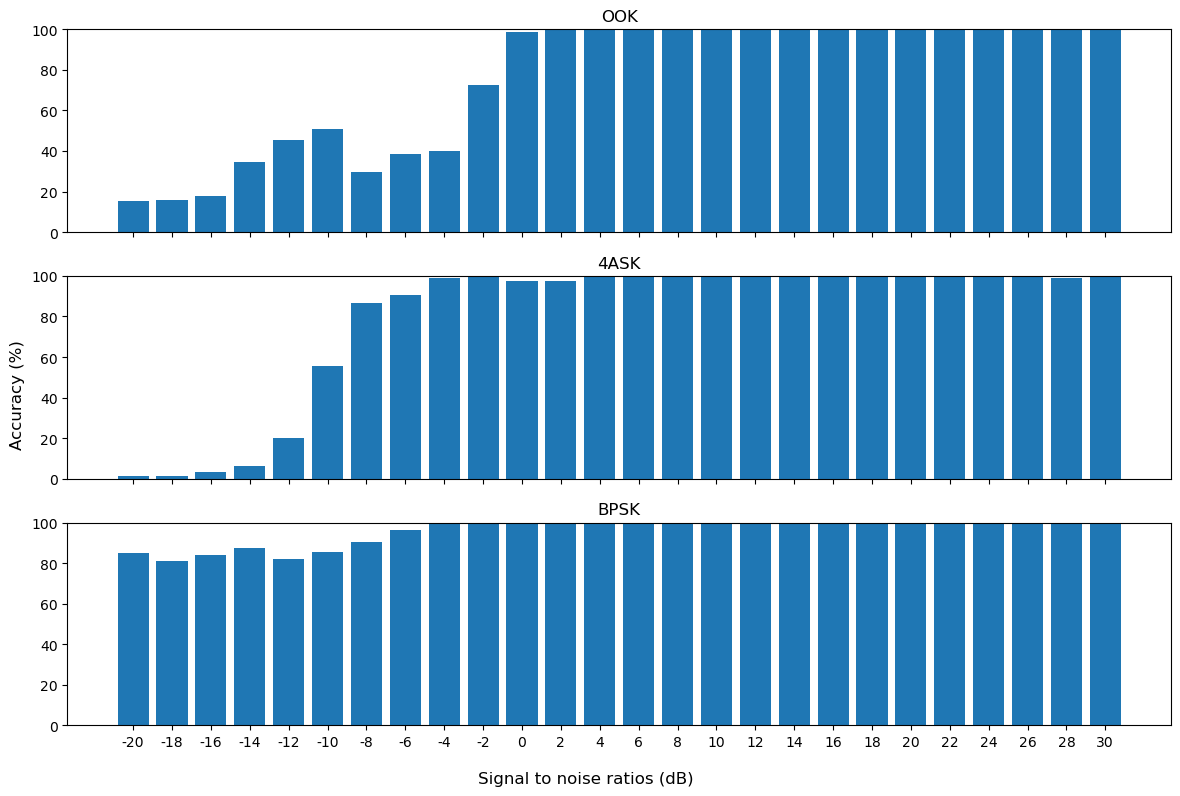

In [17]:
train_test_plots(DDrCNN(),'DDrCNN',verbose=True)

In [25]:
conv2ds_CNN_NET= [m for m in CNN_NET().modules() if isinstance(m, torch.nn.Conv2d)]
conv2ds_DDrCNN= [m for m in DDrCNN().modules() if isinstance(m, torch.nn.Conv2d)]
print(f"Found for CNN_NET model {len(conv2ds_CNN_NET)} and Conv2d layer {conv2ds_CNN_NET}")
print(f"Found for DDrCNN model {len(conv2ds_DDrCNN)} and Conv2d layer {conv2ds_DDrCNN}")

Found for CNN_NET model 0 and Conv2d layer []
Found for DDrCNN model 0 and Conv2d layer []


In [31]:

class DDrCNN2D(nn.Module):
    """
    2D-Conv version of your DDrCNN: 
      – Input is (batch, 1, 2, 1024)
      – First conv uses a (2×3) kernel to collapse height → 1
      – Then we have a stack of (1×3) time-only convs / pools
      – Finally a small MLP head
    """
    def __init__(self, input_shape=(2, 1024), num_classes=24):
        super(DDrCNN2D, self).__init__()
        H, W = input_shape  # H=2, W=1024

        self.backbone = nn.Sequential(
            # conv #1: collapse H=2→1
            nn.Conv2d(1, 24, kernel_size=(2,3), padding=(0,1)),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,2)),    # now (batch,24,1, W/2)

            # conv #2
            nn.Conv2d(24,24,kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,2)),

            # conv #3
            nn.Conv2d(24,48,kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,2)),

            # conv #4
            nn.Conv2d(48,48,kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,2)),
        )

        # figure out flattened dims
        with torch.no_grad():
            dummy = torch.zeros(1, 1, H, W)
            feat = self.backbone(dummy)
            flat_dim = feat.numel()  # C*H'*W'

        # classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        # x is (batch, 2, 1024) → make it 'grayscale image' (batch,1,2,1024)
        x = x.unsqueeze(1)
        x = self.backbone(x)
        x = self.classifier(x)
        return x


In [32]:
summary(DDrCNN2D().to('cuda'), (batch_size,n_channels, frame_size))

Layer (type:depth-idx)                   Output Shape              Param #
DDrCNN2D                                 [32, 24]                  --
├─Sequential: 1-1                        [32, 48, 1, 64]           --
│    └─Conv2d: 2-1                       [32, 24, 1, 1024]         168
│    └─BatchNorm2d: 2-2                  [32, 24, 1, 1024]         48
│    └─ReLU: 2-3                         [32, 24, 1, 1024]         --
│    └─MaxPool2d: 2-4                    [32, 24, 1, 512]          --
│    └─Conv2d: 2-5                       [32, 24, 1, 512]          1,752
│    └─BatchNorm2d: 2-6                  [32, 24, 1, 512]          48
│    └─ReLU: 2-7                         [32, 24, 1, 512]          --
│    └─MaxPool2d: 2-8                    [32, 24, 1, 256]          --
│    └─Conv2d: 2-9                       [32, 48, 1, 256]          3,504
│    └─BatchNorm2d: 2-10                 [32, 48, 1, 256]          96
│    └─ReLU: 2-11                        [32, 48, 1, 256]          --
│    └─M

Analyzing test dataset distribution...


Analyzing dataset: 100%|█| 73216/73216 [00


Modulation distribution in dataset:
  OOK: 6656 samples
  4ASK: 6656 samples
  BPSK: 6656 samples
  QPSK: 6656 samples
  8PSK: 6656 samples
  16QAM: 6656 samples
  AM-SSB-SC: 6656 samples
  AM-DSB-SC: 6656 samples
  FM: 6656 samples
  GMSK: 6656 samples
  OQPSK: 6656 samples

PSK modulation distribution:

BPSK distribution across SNRs:
  SNR -20dB: 256 samples
  SNR -18dB: 256 samples
  SNR -16dB: 256 samples
  SNR -14dB: 256 samples
  SNR -12dB: 256 samples
  SNR -10dB: 256 samples
  SNR -8dB: 256 samples
  SNR -6dB: 256 samples
  SNR -4dB: 256 samples
  SNR -2dB: 256 samples
  SNR 0dB: 256 samples
  SNR 2dB: 256 samples
  SNR 4dB: 256 samples
  SNR 6dB: 256 samples
  SNR 8dB: 256 samples
  SNR 10dB: 256 samples
  SNR 12dB: 256 samples
  SNR 14dB: 256 samples
  SNR 16dB: 256 samples
  SNR 18dB: 256 samples
  SNR 20dB: 256 samples
  SNR 22dB: 256 samples
  SNR 24dB: 256 samples
  SNR 26dB: 256 samples
  SNR 28dB: 256 samples
  SNR 30dB: 256 samples

QPSK distribution across SNRs:
  SNR

  3%|  | 1/30 [00:33<16:14, 33.61s/epochs]

Epoch 0 (train) -- loss: 1.0323 accuracy: 0.6024
Epoch 0 (valid) -- loss: 0.8533 accuracy: 0.6734


  7%|▏ | 2/30 [01:14<17:46, 38.09s/epochs]

Epoch 1 (train) -- loss: 0.8248 accuracy: 0.6890
Epoch 1 (valid) -- loss: 0.8816 accuracy: 0.6692


 10%|▏ | 3/30 [01:56<17:54, 39.80s/epochs]

Epoch 2 (train) -- loss: 0.7905 accuracy: 0.7020
Epoch 2 (valid) -- loss: 0.9591 accuracy: 0.6480


 13%|▎ | 4/30 [02:40<18:00, 41.56s/epochs]

Epoch 3 (train) -- loss: 0.7669 accuracy: 0.7106
Epoch 3 (valid) -- loss: 0.8865 accuracy: 0.6745


 17%|▎ | 5/30 [03:26<17:56, 43.04s/epochs]

Epoch 4 (train) -- loss: 0.7538 accuracy: 0.7152
Epoch 4 (valid) -- loss: 0.8344 accuracy: 0.6868


 20%|▍ | 6/30 [04:11<17:31, 43.83s/epochs]

Epoch 5 (train) -- loss: 0.7413 accuracy: 0.7193
Epoch 5 (valid) -- loss: 0.8277 accuracy: 0.6894


 23%|▍ | 7/30 [04:56<16:52, 44.01s/epochs]

Epoch 6 (train) -- loss: 0.7324 accuracy: 0.7226
Epoch 6 (valid) -- loss: 0.9885 accuracy: 0.6597


 27%|▌ | 8/30 [05:41<16:16, 44.38s/epochs]

Epoch 7 (train) -- loss: 0.7242 accuracy: 0.7251
Epoch 7 (valid) -- loss: 1.5042 accuracy: 0.5827


 30%|▌ | 9/30 [06:28<15:48, 45.16s/epochs]

Epoch 8 (train) -- loss: 0.7188 accuracy: 0.7275
Epoch 8 (valid) -- loss: 1.0188 accuracy: 0.6584


 33%|▎| 10/30 [07:14<15:10, 45.54s/epochs]

Epoch 9 (train) -- loss: 0.7106 accuracy: 0.7302
Epoch 9 (valid) -- loss: 0.7230 accuracy: 0.7259


 37%|▎| 11/30 [08:00<14:26, 45.59s/epochs]

Epoch 10 (train) -- loss: 0.7056 accuracy: 0.7314
Epoch 10 (valid) -- loss: 0.7367 accuracy: 0.7209


 40%|▍| 12/30 [08:45<13:38, 45.46s/epochs]

Epoch 11 (train) -- loss: 0.7009 accuracy: 0.7337
Epoch 11 (valid) -- loss: 0.7306 accuracy: 0.7230


 43%|▍| 13/30 [09:31<12:53, 45.50s/epochs]

Epoch 12 (train) -- loss: 0.6948 accuracy: 0.7367
Epoch 12 (valid) -- loss: 0.8098 accuracy: 0.7064


 47%|▍| 14/30 [10:16<12:07, 45.44s/epochs]

Epoch 13 (train) -- loss: 0.6895 accuracy: 0.7378
Epoch 13 (valid) -- loss: 0.7026 accuracy: 0.7346


 50%|▌| 15/30 [11:01<11:19, 45.29s/epochs]

Epoch 14 (train) -- loss: 0.6851 accuracy: 0.7401
Epoch 14 (valid) -- loss: 0.7189 accuracy: 0.7282


 53%|▌| 16/30 [11:46<10:34, 45.33s/epochs]

Epoch 15 (train) -- loss: 0.6829 accuracy: 0.7404
Epoch 15 (valid) -- loss: 0.7787 accuracy: 0.7134


 57%|▌| 17/30 [12:32<09:49, 45.35s/epochs]

Epoch 16 (train) -- loss: 0.6764 accuracy: 0.7423
Epoch 16 (valid) -- loss: 1.0132 accuracy: 0.6739


 60%|▌| 18/30 [13:17<09:02, 45.24s/epochs]

Epoch 17 (train) -- loss: 0.6736 accuracy: 0.7440
Epoch 17 (valid) -- loss: 0.6965 accuracy: 0.7394


 63%|▋| 19/30 [14:01<08:15, 45.05s/epochs]

Epoch 18 (train) -- loss: 0.6702 accuracy: 0.7451
Epoch 18 (valid) -- loss: 0.7885 accuracy: 0.7139


 67%|▋| 20/30 [14:46<07:29, 44.91s/epochs]

Epoch 19 (train) -- loss: 0.6671 accuracy: 0.7464
Epoch 19 (valid) -- loss: 0.7749 accuracy: 0.7172


 70%|▋| 21/30 [15:31<06:44, 44.98s/epochs]

Epoch 20 (train) -- loss: 0.6644 accuracy: 0.7479
Epoch 20 (valid) -- loss: 0.8500 accuracy: 0.6976


 73%|▋| 22/30 [16:17<06:02, 45.27s/epochs]

Epoch 21 (train) -- loss: 0.6613 accuracy: 0.7483
Epoch 21 (valid) -- loss: 0.8698 accuracy: 0.7021


 77%|▊| 23/30 [17:02<05:17, 45.31s/epochs]

Epoch 22 (train) -- loss: 0.6593 accuracy: 0.7490
Epoch 22 (valid) -- loss: 0.7163 accuracy: 0.7372


 80%|▊| 24/30 [17:48<04:32, 45.36s/epochs]

Epoch 23 (train) -- loss: 0.6568 accuracy: 0.7501
Epoch 23 (valid) -- loss: 0.7743 accuracy: 0.7212


 83%|▊| 25/30 [18:33<03:46, 45.36s/epochs]

Epoch 24 (train) -- loss: 0.6551 accuracy: 0.7509
Epoch 24 (valid) -- loss: 0.7808 accuracy: 0.7244


 87%|▊| 26/30 [19:18<03:00, 45.25s/epochs]

Epoch 25 (train) -- loss: 0.6519 accuracy: 0.7516
Epoch 25 (valid) -- loss: 0.7059 accuracy: 0.7417


 90%|▉| 27/30 [20:05<02:16, 45.60s/epochs]

Epoch 26 (train) -- loss: 0.6500 accuracy: 0.7531
Epoch 26 (valid) -- loss: 0.8540 accuracy: 0.7056


 93%|▉| 28/30 [20:54<01:33, 46.68s/epochs]

Epoch 27 (train) -- loss: 0.6491 accuracy: 0.7526
Epoch 27 (valid) -- loss: 0.7463 accuracy: 0.7305


 97%|▉| 29/30 [21:44<00:47, 47.68s/epochs]

Epoch 28 (train) -- loss: 0.6471 accuracy: 0.7533
Epoch 28 (valid) -- loss: 0.8691 accuracy: 0.7099


100%|█| 30/30 [22:33<00:00, 45.12s/epochs]


Epoch 29 (train) -- loss: 0.6457 accuracy: 0.7544
Epoch 29 (valid) -- loss: 0.7519 accuracy: 0.7298

Plotting training history...


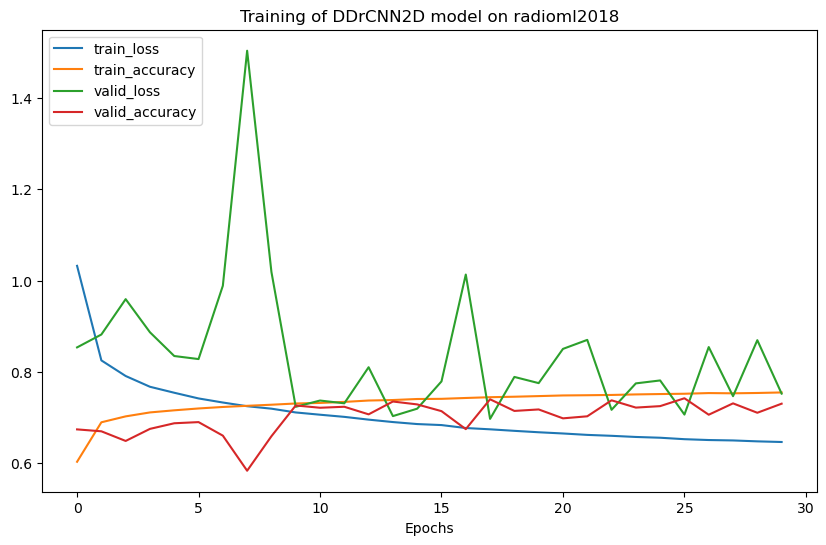


Evaluating and plotting test accuracy...
target modulation:['OOK', '4ASK', 'BPSK', 'QPSK', '8PSK', '16QAM', 'AM-SSB-SC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']
target SNR: [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]


Testing model: 100%|█| 572/572 [00:02<00:0


Accuracy on test dataset: 71.06%
Modulation OOK: 6656 test samples
Modulation 4ASK: 6656 test samples
Modulation BPSK: 6656 test samples
Modulation QPSK: 6656 test samples
Modulation 8PSK: 6656 test samples
Modulation 16QAM: 6656 test samples
Modulation AM-SSB-SC: 6656 test samples
Modulation AM-DSB-SC: 6656 test samples
Modulation FM: 6656 test samples
Modulation GMSK: 6656 test samples
Modulation OQPSK: 6656 test samples


Calculating per-modulation accuracies: 100


Highlighting PSK modulation: ['BPSK', 'QPSK', '8PSK', 'OQPSK']


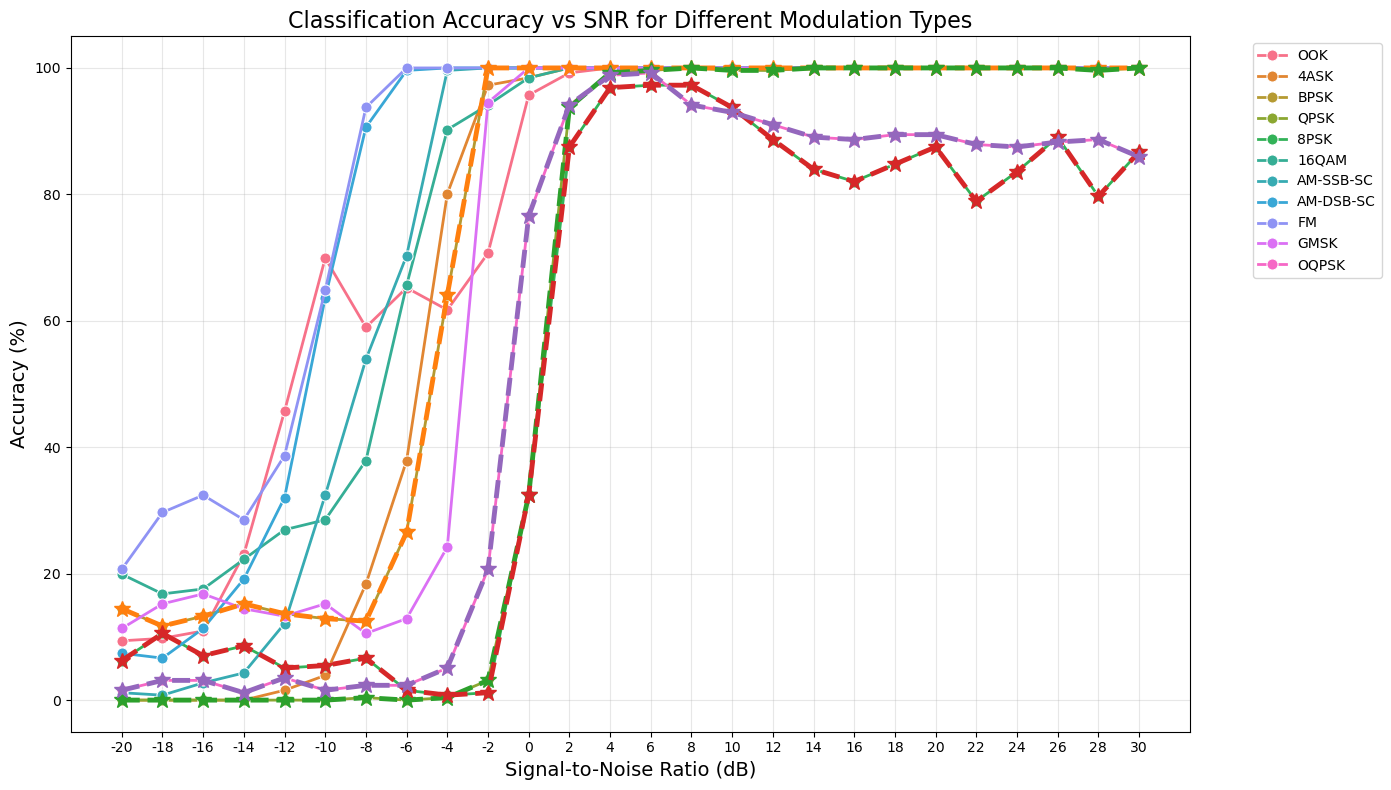

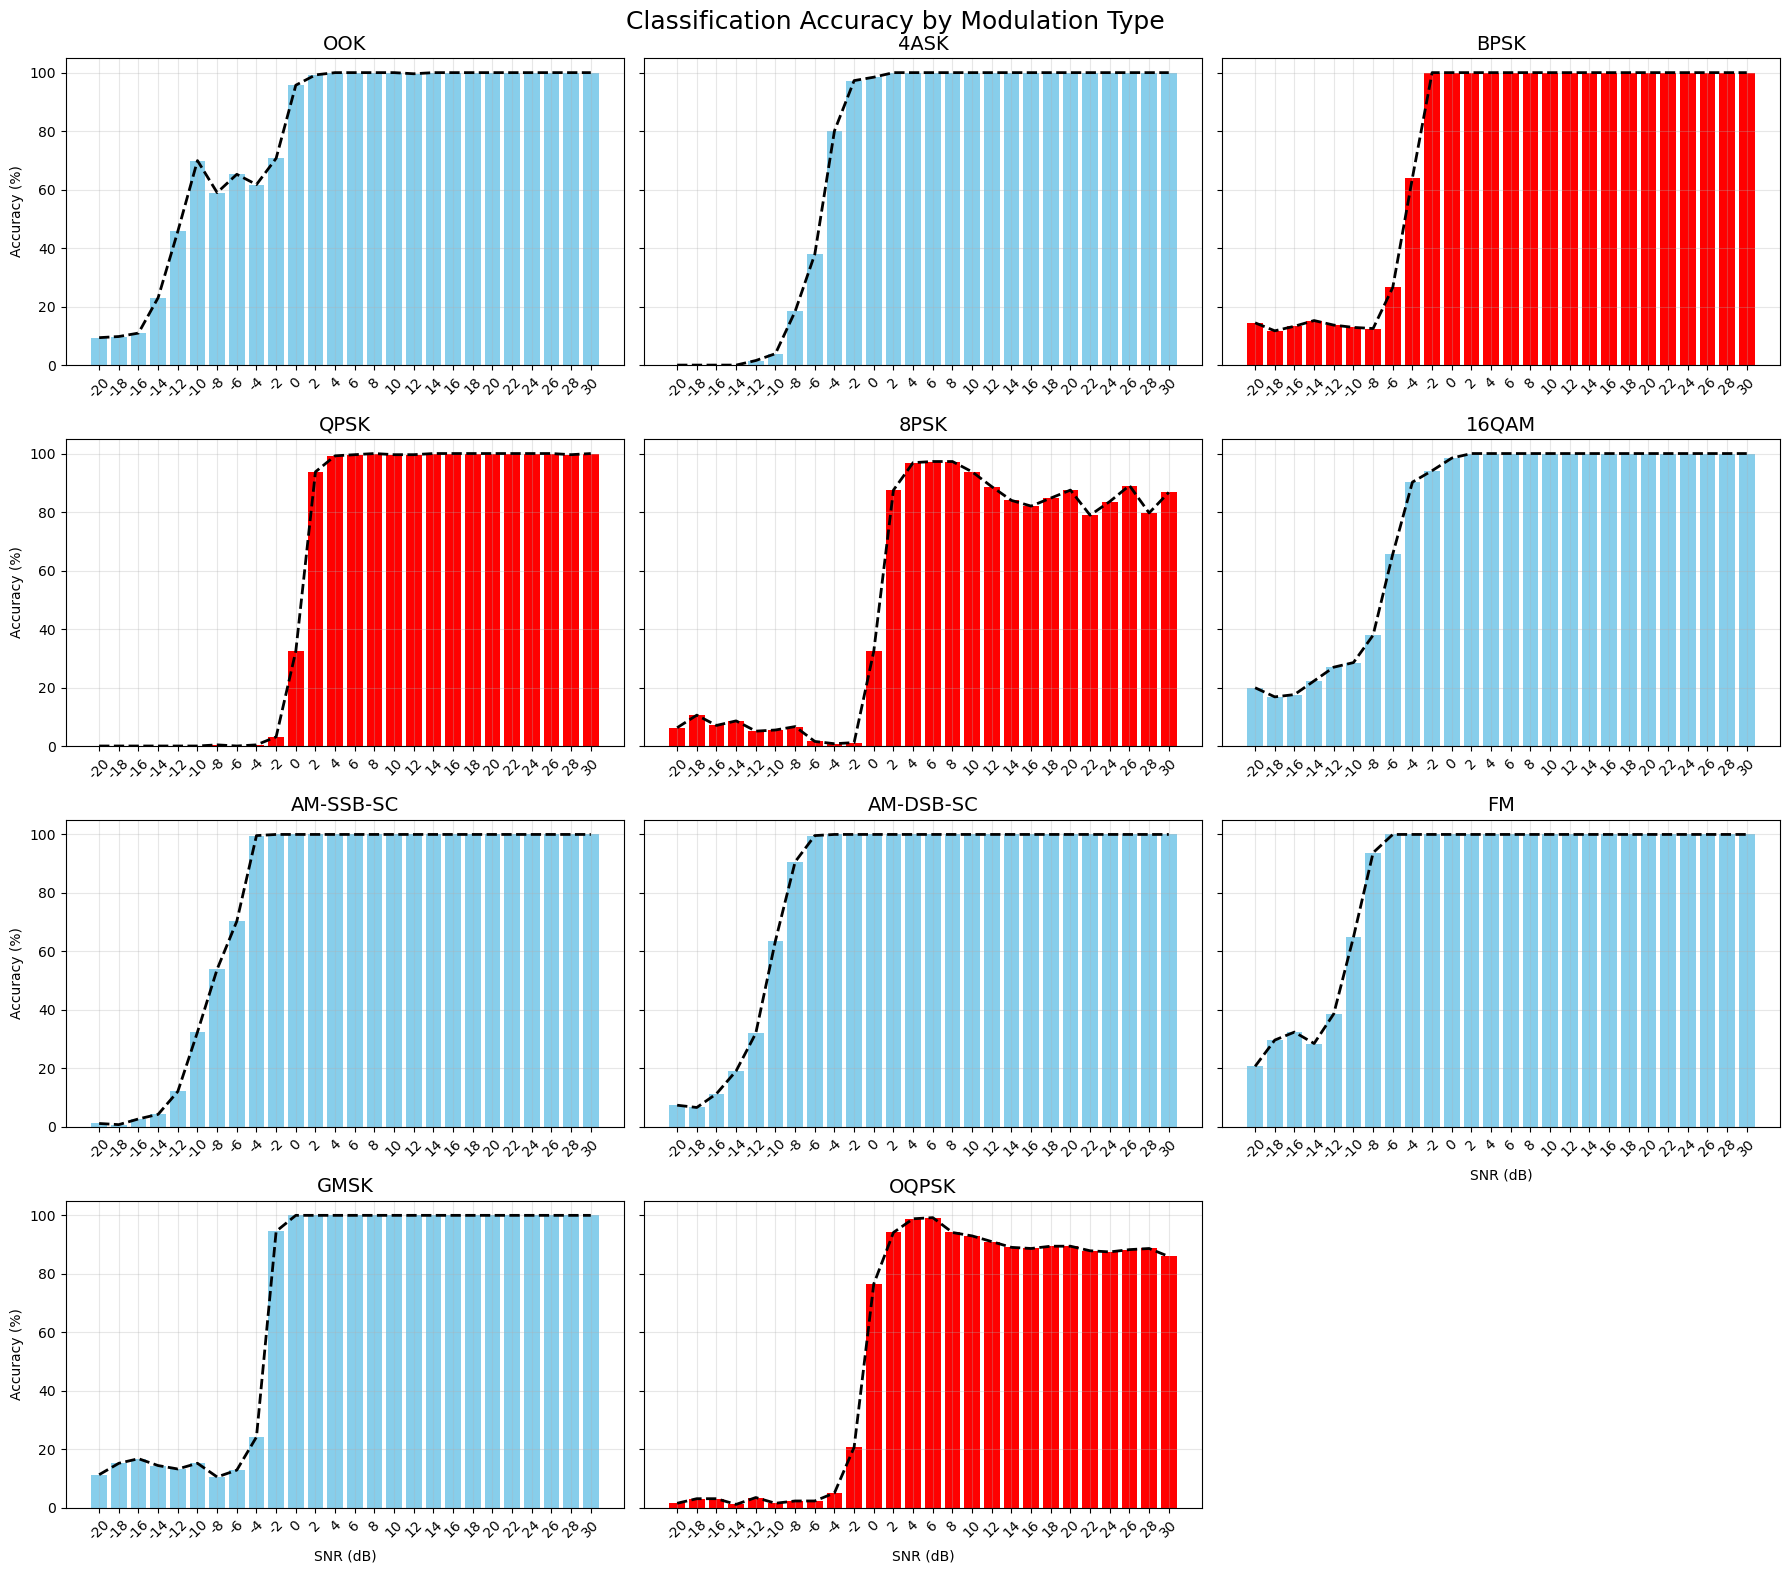

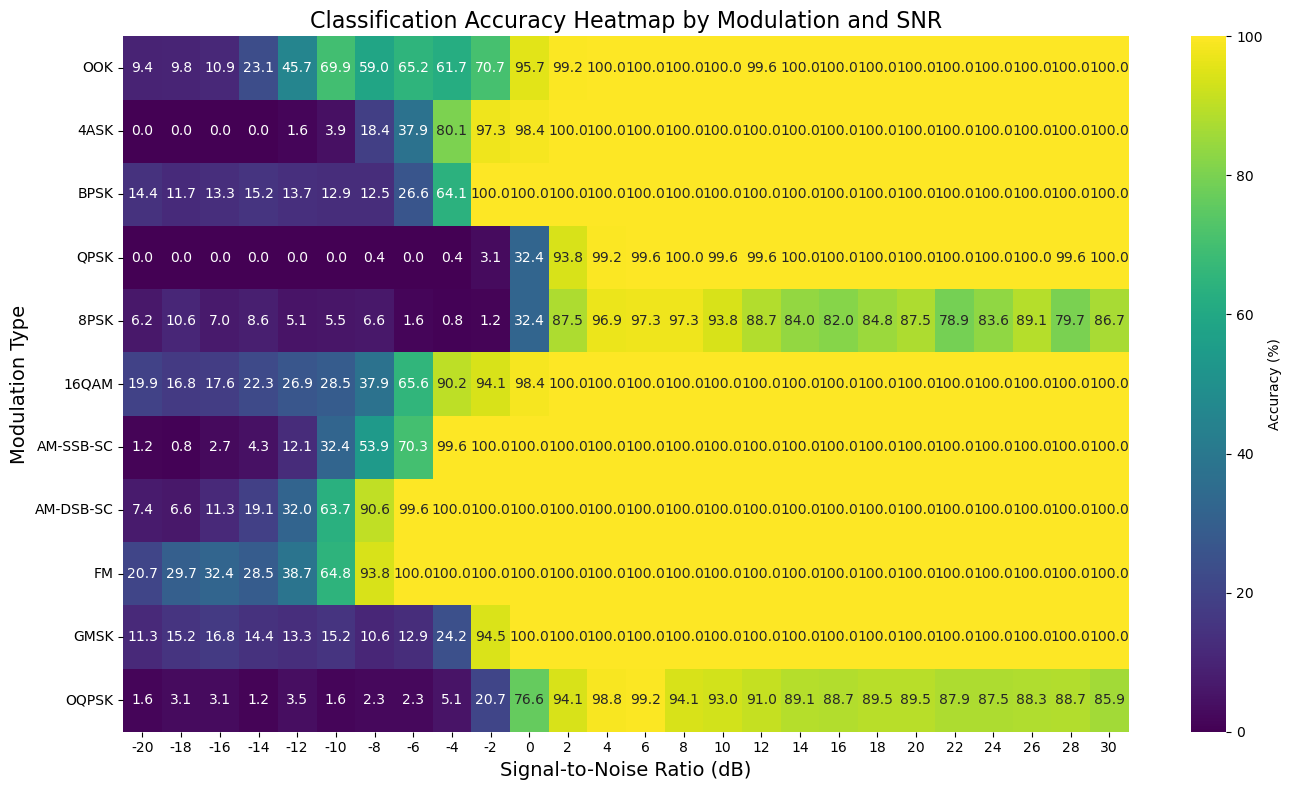

(DDrCNN2D(
   (backbone): Sequential(
     (0): Conv2d(1, 24, kernel_size=(2, 3), stride=(1, 1), padding=(0, 1))
     (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
     (4): Conv2d(24, 24, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
     (5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): ReLU(inplace=True)
     (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
     (8): Conv2d(24, 48, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
     (9): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (10): ReLU(inplace=True)
     (11): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
     (12): Conv2d(48, 48, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
     (13): Bat

In [33]:
improved_train_test_plots(
    model=DDrCNN2D(),
    model_name='DDrCNN2D',  # Name goes here
    device='cuda',
    verbose=True,
    num_epoch=30
)

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def compute_confusion_matrix(model, dataloader, classes, device='cuda'):
    # Move the model to the specified device
    model.to(device) # This moves the model parameters to the device

    # DEBUG: Check the device of the first parameter of the model
    print(f"Model device after .to(device): {next(model.parameters()).device}")

    model.eval()

    Y_true = []
    Y_pred = []

    with torch.no_grad():
        for x, y, _ in dataloader: # Assuming your dataloader yields x, y, and some other metadata
            x, y = x.to(device), y.to(device)

            # DEBUG: Check input tensor device
            # print(f"Input x device: {x.device}")

            logits = model(x)
            predictions = torch.argmax(logits, dim=1)

            Y_true.extend(y.cpu().numpy())
            Y_pred.extend(predictions.cpu().numpy())

    cm = confusion_matrix(Y_true, Y_pred, labels=np.arange(len(classes)))

    # Assuming ConfusionMatrixDisplay and plt are for displaying
    # If you only need the cm array, you can remove the display part from here
    # or make it optional.
    try:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error during plotting confusion matrix: {e}")
        print("Returning raw confusion matrix instead.")

    return cm

Model device after .to(device): cuda:0


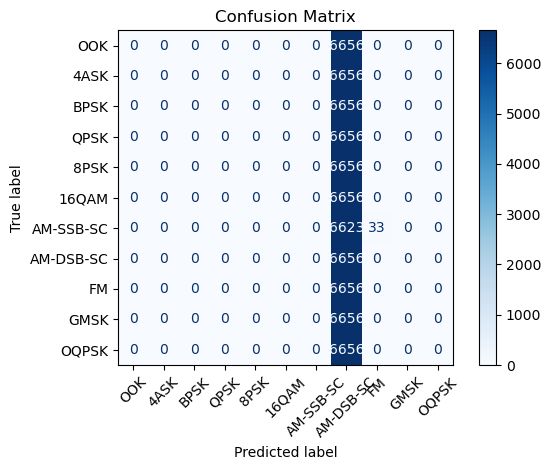

array([[   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6623,   33,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6656,    0,    0,    0]])

In [52]:
modulation_classes = test_dl.dataset.target_modulations
compute_confusion_matrix(CNN_NET(), test_dl, modulation_classes, device='cuda')